# Decision Tree Model Selection 

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Step 1: Build DataFrame and Define ML Problem

We will work with the "cell2celltrain" data set. This data set is already preprocessed, with the proper formatting, outliers and missing values taken care of, and all numerical columns scaled to the [0, 1] interval. One-hot encoding has been performed on all categorical columns. It is ready for modeling. Run the cell below to load the data set and save it to DataFrame `df`. 

In [3]:
filename = os.path.join(os.getcwd(), "..", "..", "data", "cell2celltrain_cv.csv")
df = pd.read_csv(filename, header=0)

#### Define the Label

This is a binary classification problem in which we will predict customer churn. The label is the `Churn` column.

#### Identify Features

Our features will be all of the remaining columns in the dataset.

## Step 2: Create Labeled Examples from the Data Set 

Let's obtain columns from our data set to create labeled examples. 
In the code cell below:
* Assign the label column to the variable `y`. 
* Assign all other columns to the variable `X`. 


In [4]:
y = df['Churn']
X = df.drop(columns='Churn')

## Step 3: Create Training and Test Data Sets

When performing model selection, we split our data into 3 subsets: training, validation, and test. We train on our training set, evaluate on our validation set, make necessary tweaks to the hyperparameters, and continue this process until we are content with our model's performance. We save our test set for the very last and final evaluation of how well our model generalizes to new data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

### Inspect the Training and Test Data Sets

In [6]:
print(X_train.shape)
print(X_test.shape)

(45942, 84)
(5105, 84)


In [7]:
X_train.head()

,CustomerID,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,...,Occupation_Crafts,Occupation_Homemaker,Occupation_Other,Occupation_Professional,Occupation_Retired,Occupation_Self,Occupation_Student,Married_False,Married_True,Married_nan
45106,3356966,False,False,True,False,False,True,False,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38896,3310250,True,False,True,False,False,True,True,True,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29853,3237338,False,False,True,False,False,True,False,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33048,3263222,False,False,True,False,False,True,True,True,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
21061,3165118,False,False,True,False,False,False,False,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Step 4: Perform Decision Tree Model Selection

Our goal is to find the optimal choice of hyperparameter `max_depth` (the maximum depth of the tree). We want to train decision tree models on the training data set, with different values of hyperparameter `max_depth`, and find the model that results in the best cross-validation (CV) score.

The code cell below contains a list of four values for `max_depth`.

In [8]:
hyperparams = [2**n for n in range(2,5)]
hyperparams

[4, 8, 16]

In [9]:
print('Running k-fold Cross-Validation...')

accuracy_scores = []

for md in hyperparams:
    
    # 1. Create a DecisionTreeClassifier model object
    model = DecisionTreeClassifier(max_depth=md, min_samples_leaf=1)
    
    # 2. Perform a k-fold cross-validation for the decision tree
    acc_score = cross_val_score(model, X_train, y_train, cv=5)
    
    # 3. Find the mean of the resulting accuracy scores 
    acc_mean = acc_score.mean()
    
    # 4. Append the mean score to the list accuracy_scores
    accuracy_scores.append(acc_mean)
    
print('Done\n')

for s in range(len(accuracy_scores)):
    print('Accuracy score for max_depth {0}: {1}'.format(hyperparams[s], accuracy_scores[s]))

Running k-fold Cross-Validation...
Done

Accuracy score for max_depth 4: 0.7145966887118208
Accuracy score for max_depth 8: 0.7097427395752895
Accuracy score for max_depth 16: 0.6696269644958412


In [10]:
# 1. Create a DecisionTreeClassifier model object and assign it to the variable 'model'
model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1)
    
# 2. Fit the model to the training data 
model.fit(X_train, y_train)

# 3. Use the predic() method to make predictions on the test data and assign the results to 
# the variable 'class_label_predictions'
class_label_predictions = model.predict(X_test)

# 4. Compute the accuracy score and assign the result to the variable 'acc_score'
acc_score = accuracy_score(y_test, class_label_predictions)

print(acc_score)

0.7171400587659158


## Step 5: Model Selection Using a Validation Curve

There are multiple functions in `sklearn` that implement some version of model selection in which they search over different combinations of possible hyperparameter values to find the set that results in the best cross-validation (CV) score.

Some of these functions return the validation scores only, some other ones return both the validation and the training set performance (how well the model fits to the data it was trained on), and others have useful attributes where you can retrieve the value of the best-scoring hyperparameter with a simple command. Let's review one of these: the scikit-learn `validation_curve()` 

In [11]:
from sklearn.model_selection import validation_curve

The code cell below uses the `validation_curve()` function to train three decision tree models with different values for the `max_depth` hyperparameter (same values as above). It performs cross-validation on each model. It returns the training and validation accuracy scores for each k-fold cross-validation performed.

The function expects the following inputs: a model object, the training data, the name of the hyperparameter (in this case, `max_depth`), a range of hyperparameter values, and the number of cross-validation folds (k). Note that for a classifier, the function `cross_val_score()` uses the scikit-learn `accuracy_score` metric by default. 


In [12]:
print('Running Validation Curve Implementation...')

# Create a DecisionTreeClassifier model object without supplying arguments
model = DecisionTreeClassifier()

# Create a range of hyperparameter values for 'max_depth'. Note these are the same values as those we used above
hyperparams = [2**n for n in range(2,5)]

# Call the validation_curve() function with the appropriate parameters
training_scores, validation_scores = validation_curve(model, X_train, y_train,
                                       param_name = "max_depth",
                                       param_range = hyperparams,
                                        cv = 5)

print('Done\n')

print(validation_scores)


Running Validation Curve Implementation...
Done

[[0.71400588 0.7141147  0.7152808  0.71538964 0.71419242]
 [0.71128523 0.70682338 0.70700914 0.71060078 0.71234219]
 [0.66481663 0.67167265 0.6626034  0.67152808 0.67936439]]


In [13]:
mean_validation_scores = np.mean(validation_scores, axis = 1)
for h in range(0, len(hyperparams)):
    print('Results of cross-validation for max_depth of {0}: {1}'.format(hyperparams[h], mean_validation_scores[h]))
    

Results of cross-validation for max_depth of 4: 0.7145966887118208
Results of cross-validation for max_depth of 8: 0.7096121439136238
Results of cross-validation for max_depth of 16: 0.6699970289664636


The code cell below plots the validation curve, with the values of the parameter `max_depth` on the $x$-axis, and the accuracy scores on the validation set on the $y$-axis.

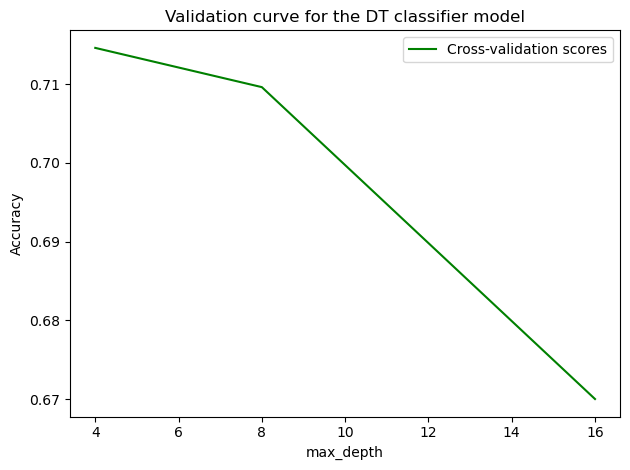

In [14]:
sns.lineplot(x=hyperparams, y=mean_validation_scores, label = "Cross-validation scores", color = 'g')

plt.title("Validation curve for the DT classifier model")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')

plt.show()

## Step 6: Model Selection Using Grid Search Cross-Validation

The function `validation_curve()` finds the best value for one hyperparameter. What if we want to find the best combination of hyperparameter values for more than one hyperparameter?

Scikit-learn has a class named `GridSearchCV` that allows to search over different combinations of possible hyperparameter values to find the set that results in the best cross-validation (CV) score.

It enables us to find the best-performing combination of values for several hyperparameters. 

###  a. Set Up the Parameter Grid

In [15]:
# Create a range of hyperparameter values for 'max_depth'. 
# Note these are the same values as those we used above
hyperparams_depth = [2**n for n in range(2,5)]

# Create a range of hyperparameter values for 'min_samples_leaf'. 
hyperparams_leaf = [25*2**n for n in range(0,3)]

# Create parameter grid.
param_grid={'max_depth':hyperparams_depth, 'min_samples_leaf':hyperparams_leaf}
param_grid

{'max_depth': [4, 8, 16], 'min_samples_leaf': [25, 50, 100]}

### b. Perform Grid Search Cross-Validation
First, lets import `GridSearchCV`:

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
print('Running Grid Search...')

# 1. Create a DecisionTreeClassifier model object without supplying arguemnts
model = DecisionTreeClassifier()
 
# 2. Run a Grid Search with 5-fold cross-validation using the model.
#   Pass all relevant parameters to GridSearchCV and assign the output to the object 'grid'
grid = GridSearchCV(model, param_grid, cv=5)


# 3. Fit the model on the training data and assign the fitted model to the 
#    variable grid_search
grid_search = grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


### c. Identify the Best Hyperparameter Values

The fitted model object `grid_search` has built-in attributes that you can access to examine the results.

In [18]:
# Print best-performing hyperparameter configuration
print('Optimal hyperparameters: {0}'.format(grid_search.best_params_))

# print best accuracy score resulting from this configuration
print('Accuracy score: {0}'.format(grid_search.best_score_))

Optimal hyperparameters: {'max_depth': 4, 'min_samples_leaf': 50}
Accuracy score: 0.7147490424208727


Notice that all three model selection techniques returned the same optimal value of `max_depth`.